# Willman 1: Orbit Integration

Import necessary packages

In [1]:
import numpy as np
import scipy

from astropy import units as u
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt

import galpy
from galpy.orbit import Orbit
from galpy.util import conversion

from galpy.potential import ChandrasekharDynamicalFrictionForce
from galpy.potential import HernquistPotential, MovingObjectPotential, NonInertialFrameForce
from galpy.potential import (evaluateRforces, evaluatephitorques, evaluatezforces)

from wil1_properties import ra_w1, dec_w1, dist, dist_err, pmra_w1, pmdec_w1, vsys, mass_w1, r_half_pc, r_half_pc_err

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
A new version of galpy (1.11.1) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [2]:
# some code for prettier plots
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'axes.linewidth' : 1,
                     'ytick.major.width' : 1,
                     'ytick.minor.width' : 1,
                     'xtick.major.width' : 1,
                     'xtick.minor.width' : 1,
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12,
                     'axes.labelsize': 16,
                     'font.family': 'Serif',
                     'figure.figsize': (10, 6),
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.major.size': 8,
                     'ytick.major.size': 8,
                     'xtick.minor.size': 4,
                     'ytick.minor.size': 4})

## (1) Regular MWPotential

In [3]:
from galpy.potential import MWPotential2014

In [4]:
# define full W1 vector
c_wil1 = SkyCoord(ra = ra_w1 * u.degree, dec = dec_w1 * u.degree, distance = dist * u.kpc,
                 pm_ra_cosdec = pmra_w1[0] * u.mas/u.yr, 
                 pm_dec = pmdec_w1[0] * u.mas/u.yr,
                 radial_velocity = (vsys[0]) * u.km/u.s)

# define time steps
t_step = np.linspace(0, -1, 1001) * u.Gyr

In [5]:
o_wil1 = Orbit(c_wil1) # define orbit from coordinates
o_wil1.integrate(t_step, MWPotential2014) # integration to find orbit

In [6]:
# orbital parameters (MWPotential2014)
pericenter_wil1   = o_wil1.rperi()
apocenter_wil1    = o_wil1.rap()
eccentricity_wil1 = o_wil1.e()
zmax_wil1         = o_wil1.zmax()
ellipticity_wil1  = 1 - (1 - (eccentricity_wil1 ** 2)) ** (1/2)

# orbit values
orbit_x_wil1 = -o_wil1.x(t_step)
orbit_y_wil1 = o_wil1.y(t_step)
orbit_z_wil1 = o_wil1.z(t_step)
orbit_r_wil1 = o_wil1.r(t_step)

print("Pericenter:   {:.3f} kpc \n".format(pericenter_wil1) + \
      "Apocenter:    {:.3f} kpc\n".format(apocenter_wil1) + \
      "Eccentricity: {:.3f}\n".format(eccentricity_wil1) + \
      "Zmax:         {:.3f} kpc\n".format(zmax_wil1) + \
      "Ellipticity:  {:.3f}".format(ellipticity_wil1))

Pericenter:   24.647 kpc 
Apocenter:    43.442 kpc
Eccentricity: 0.276
Zmax:         32.323 kpc
Ellipticity:  0.039


In [7]:
### bootstrapping over errors
num = 1000 # sample size

ras  = np.full((num), ra_w1)
decs = np.full((num), dec_w1)
dists = scipy.stats.norm.rvs(loc = dist, scale = dist_err, size = num)
pmra_wil1_dist = scipy.stats.norm.rvs(loc = pmra_w1[0], scale = pmra_w1[1], size = num)
pmdec_wil1_dist = scipy.stats.norm.rvs(loc = pmdec_w1[0], scale = pmdec_w1[1], size = num)
v_dist = scipy.stats.norm.rvs(loc = vsys[0], scale = vsys[1], size = num)

# coordinates
c_bootstrap = SkyCoord(ra = ras * u.degree, dec = decs * u.degree, distance = dists * u.kpc,
                       pm_ra_cosdec = pmra_wil1_dist * u.mas/u.yr, pm_dec = pmdec_wil1_dist * u.mas/u.yr,
                       radial_velocity = v_dist * u.km/u.s)

orbits = Orbit(c_bootstrap)
orbits.integrate(t_step, MWPotential2014)

In [8]:
# print nicely
def print_vals(vals, name, unit):
    print(name + "{:.3f} + {:.3f} - {:.3f} ".format(np.percentile(vals, 50), 
                                                    np.percentile(vals, 84) - np.percentile(vals, 50),
                                                    np.percentile(vals, 50) - np.percentile(vals, 16)) + unit)

In [9]:
# orbit parameters
pericenters    = orbits.rperi()
apocenters     = orbits.rap()
eccentricities = orbits.e()
radius         = orbits.r()
orbit_fperi    = (radius - pericenters) / (apocenters - pericenters)

print_vals(pericenters,    "Pericenter:     ", "kpc")
print_vals(apocenters,     "Apocenter:      ", "kpc")
print_vals(eccentricities, "Eccentricity:   ", "")
print_vals(radius,         "Current Radius: ", "kpc")
print_vals(orbit_fperi,    "F_peri:         ", "")

print("\nPericenters > 40 kpc: {}/{}.".format(len(pericenters[pericenters > 40]), num))

Pericenter:     24.881 + 3.468 - 3.076 kpc
Apocenter:      43.451 + 0.427 - 0.452 kpc
Eccentricity:   0.271 + 0.060 - 0.061 
Current Radius: 43.179 + 0.433 - 0.425 kpc
F_peri:         0.986 + 0.003 - 0.004 

Pericenters > 40 kpc: 0/1000.


In [10]:
# orbit values
orbit_r        = np.array([])
orbit_r_lower  = np.array([])
orbit_r_upper  = np.array([])
orbit_r_lower2 = np.array([])
orbit_r_upper2 = np.array([])

for i in range(len(t_step)): # loop through to find avg for each time step
    orbit_r        = np.append(orbit_r, np.median(orbits.r(t_step[i])))
    orbit_r_lower2 = np.append(orbit_r_lower2, np.percentile(orbits.r(t_step[i]), 5))
    orbit_r_lower  = np.append(orbit_r_lower, np.percentile(orbits.r(t_step[i]), 16))
    orbit_r_upper  = np.append(orbit_r_upper, np.percentile(orbits.r(t_step[i]), 84))
    orbit_r_upper2 = np.append(orbit_r_upper2, np.percentile(orbits.r(t_step[i]), 95))

## (2) MWPotential, 1.5 halo mass

In [11]:
MWPotential2014[2] *= 1.5 # halo 50% bigger

o_inertial = Orbit(c_wil1) # define orbit from coordinates
o_inertial.integrate(t_step, MWPotential2014) # integration to find orbit

In [12]:
# orbital parameters (MWPotential2014 * 1.5)
pericenter_wil1_inertial = o_inertial.rperi()
apocenter_wil1_inertial = o_inertial.rap()
eccentricity_wil1_inertial = o_inertial.e()
zmax_wil1_inertial = o_inertial.zmax()
ellipticity_wil1_inertial = 1 - (1 - (eccentricity_wil1_inertial ** 2)) ** (1/2)

# orbit values
orbit_x_wil1_inertial = -o_inertial.x(t_step)
orbit_y_wil1_inertial = o_inertial.y(t_step)
orbit_z_wil1_inertial = o_inertial.z(t_step)
orbit_r_wil1_inertial = o_inertial.r(t_step)

print("Pericenter:   {:.3f} kpc \n".format(pericenter_wil1_inertial) + \
      "Apocenter:    {:.3f} kpc\n".format(apocenter_wil1_inertial) + \
      "Eccentricity: {:.3f}\n".format(eccentricity_wil1_inertial) + \
      "Zmax:         {:.3f} kpc\n".format(zmax_wil1_inertial) + \
      "Ellipticity:  {:.3f}".format(ellipticity_wil1_inertial))

Pericenter:   18.809 kpc 
Apocenter:    43.308 kpc
Eccentricity: 0.394
Zmax:         32.323 kpc
Ellipticity:  0.081


## (3) MWP Potential with LMC

In [13]:
# calculate LMC orbit, halo has to be 50% bigger for LMC to be bound orbit
o_lmc = Orbit.from_name('LMC')

In [14]:
# add dynamical friction
lmc_mass = 1.38 * 10.**11 * u.Msun # total mass
lmc_rhalf = 8.7 * u.kpc            # r_half
cdf_lmc = ChandrasekharDynamicalFrictionForce(GMs = lmc_mass, rhm = lmc_rhalf, dens = MWPotential2014)

time_step_lmc = np.linspace(0., -10., 1001)*u.Gyr
o_lmc.integrate(time_step_lmc, MWPotential2014 + cdf_lmc, method = 'dop853_c')

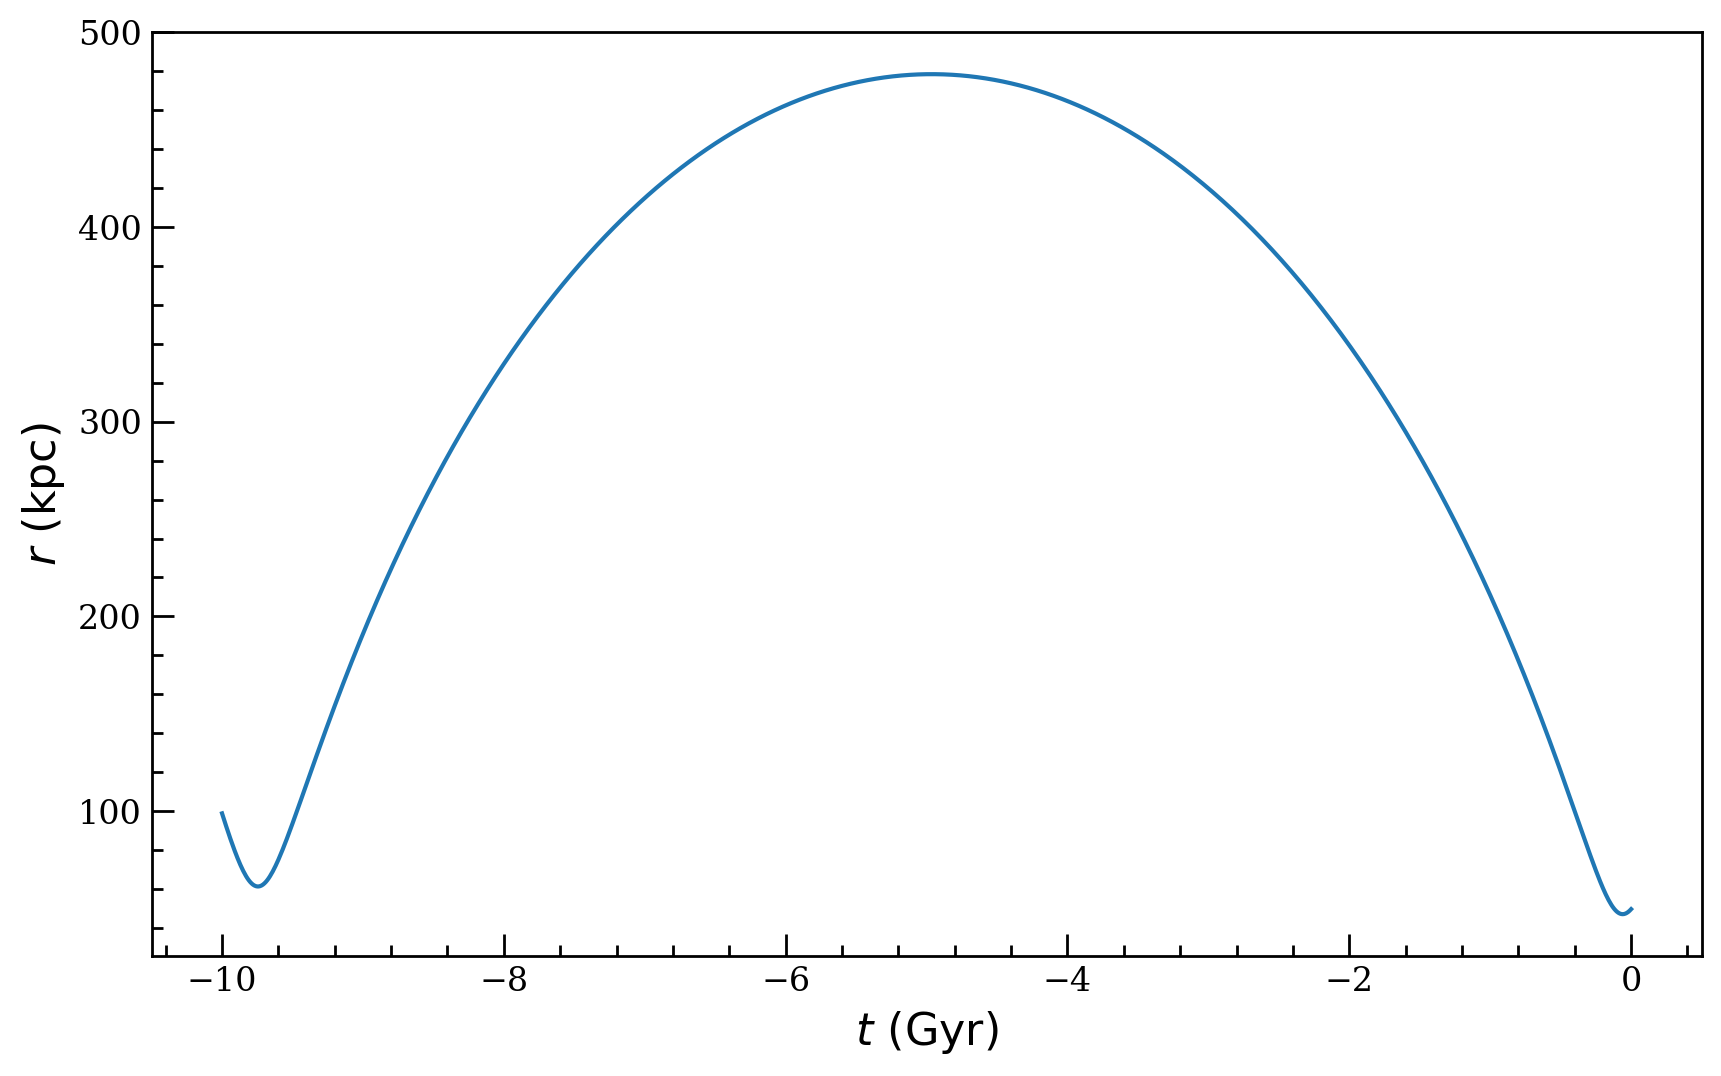

In [15]:
# plot lmc orbit
o_lmc.plot(d1 = 't', d2 = 'r')

In [16]:
# model LMC potential
lmcpot = HernquistPotential(amp = 2 * lmc_mass, a = lmc_rhalf/(1. + np.sqrt(2.))) # rhm = (1+sqrt(2)) a
moving_lmcpot = MovingObjectPotential(o_lmc, pot = lmcpot)

In [17]:
# calculate acceleration due to LMC at the origin
loc_origin = 1e-4 # small offset in R to avoid numerical issues
ax = lambda t: evaluateRforces(moving_lmcpot, loc_origin, 0., phi = 0., t = t, use_physical = False)
ay = lambda t: evaluatephitorques(moving_lmcpot, loc_origin, 0., phi = 0., t = t, use_physical = False) / loc_origin
az = lambda t: evaluatezforces(moving_lmcpot, loc_origin, 0., phi = 0., t = t, use_physical = False)

In [18]:
# interpolate
if o_lmc.time(use_physical = False)[0] > o_lmc.time(use_physical = False)[1]:
    t_intunits = o_lmc.time(use_physical = False)[::-1] # need to reverse the order for interp
else:
    t_intunits = o_lmc.time(use_physical = False)

ax4int = np.array([ax(t) for t in t_intunits])
ax_int = lambda t: np.interp(t, t_intunits, ax4int)

ay4int = np.array([ay(t) for t in t_intunits])
ay_int = lambda t: np.interp(t, t_intunits, ay4int)

az4int = np.array([az(t) for t in t_intunits])
az_int = lambda t: np.interp(t, t_intunits, az4int)

In [19]:
# set up non-inertial reference frame
nip = NonInertialFrameForce(a0 = [ax_int, ay_int, az_int])

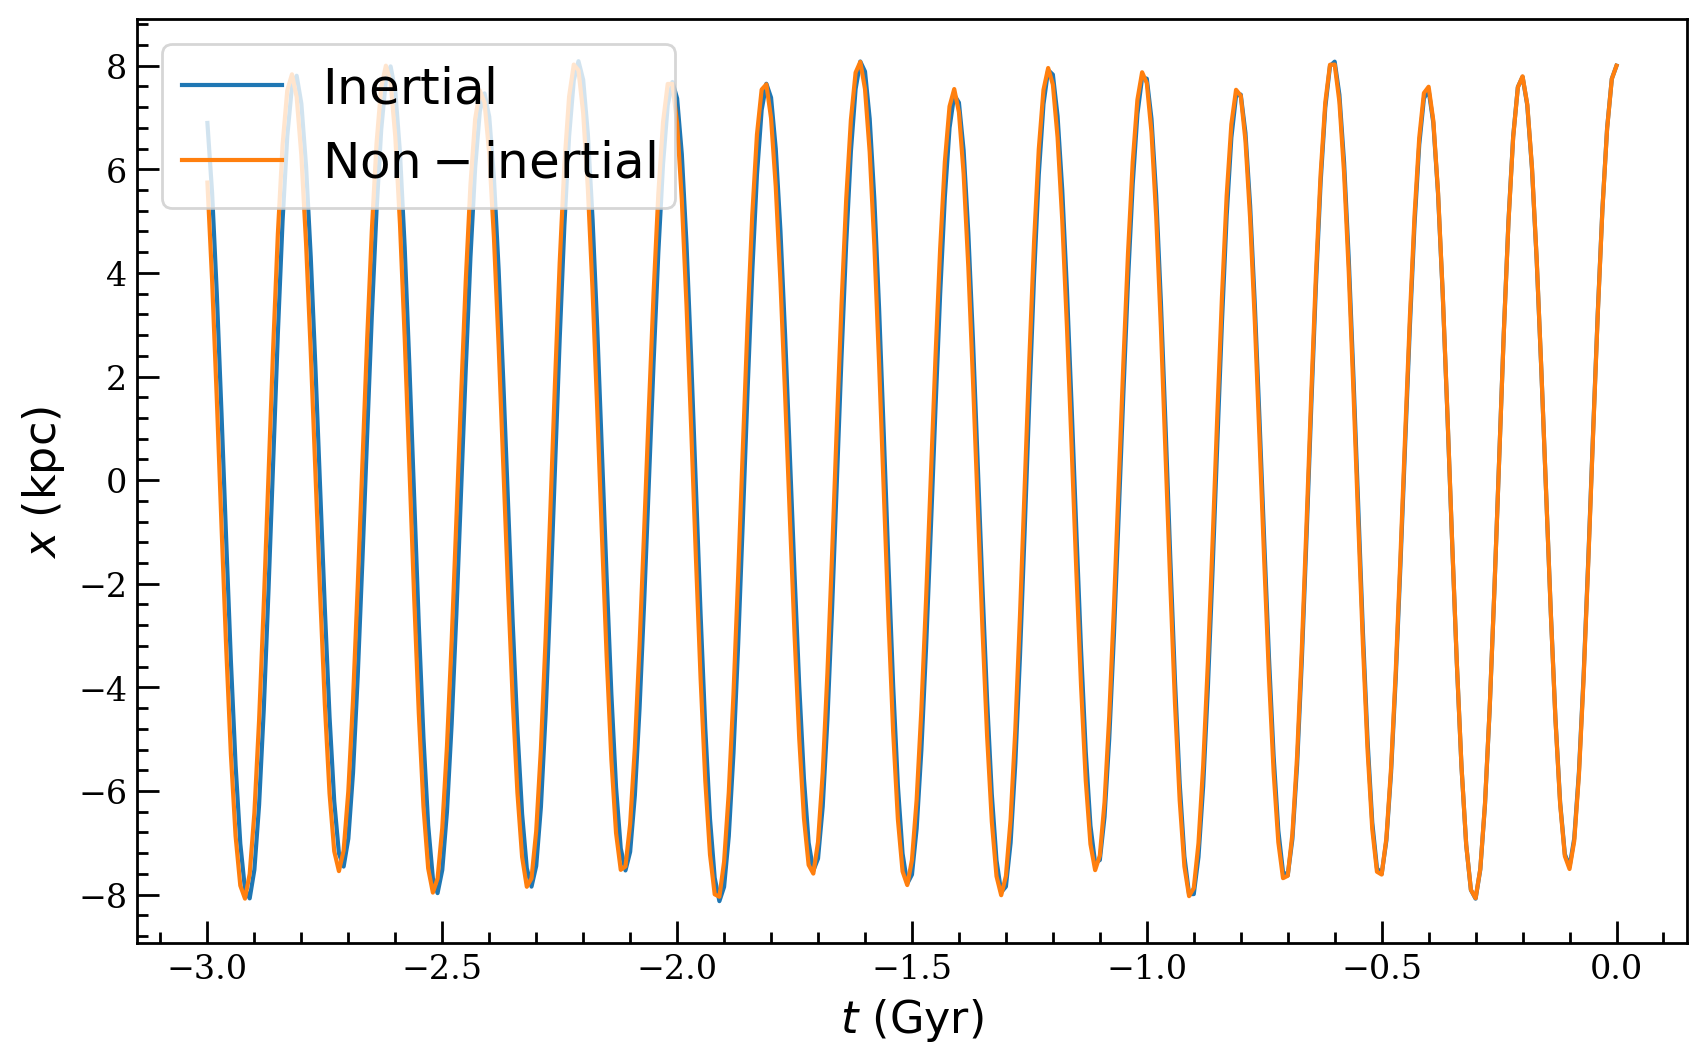

In [20]:
#Test on Sun (delete)
sunts = np.linspace(0.,-3.,301)*u.Gyr
osun_inertial = Orbit()
osun_inertial.integrate(sunts, MWPotential2014)
osun_inertial.plotx(label = r'$\mathrm{Inertial}$')

osun_noninertial = Orbit()
osun_noninertial.integrate(sunts, MWPotential2014 + nip + moving_lmcpot)
osun_noninertial.plotx(overplot = True, label = r'$\mathrm{Non-inertial}$')

plt.legend(fontsize=18., loc = 'upper left', framealpha=0.8)

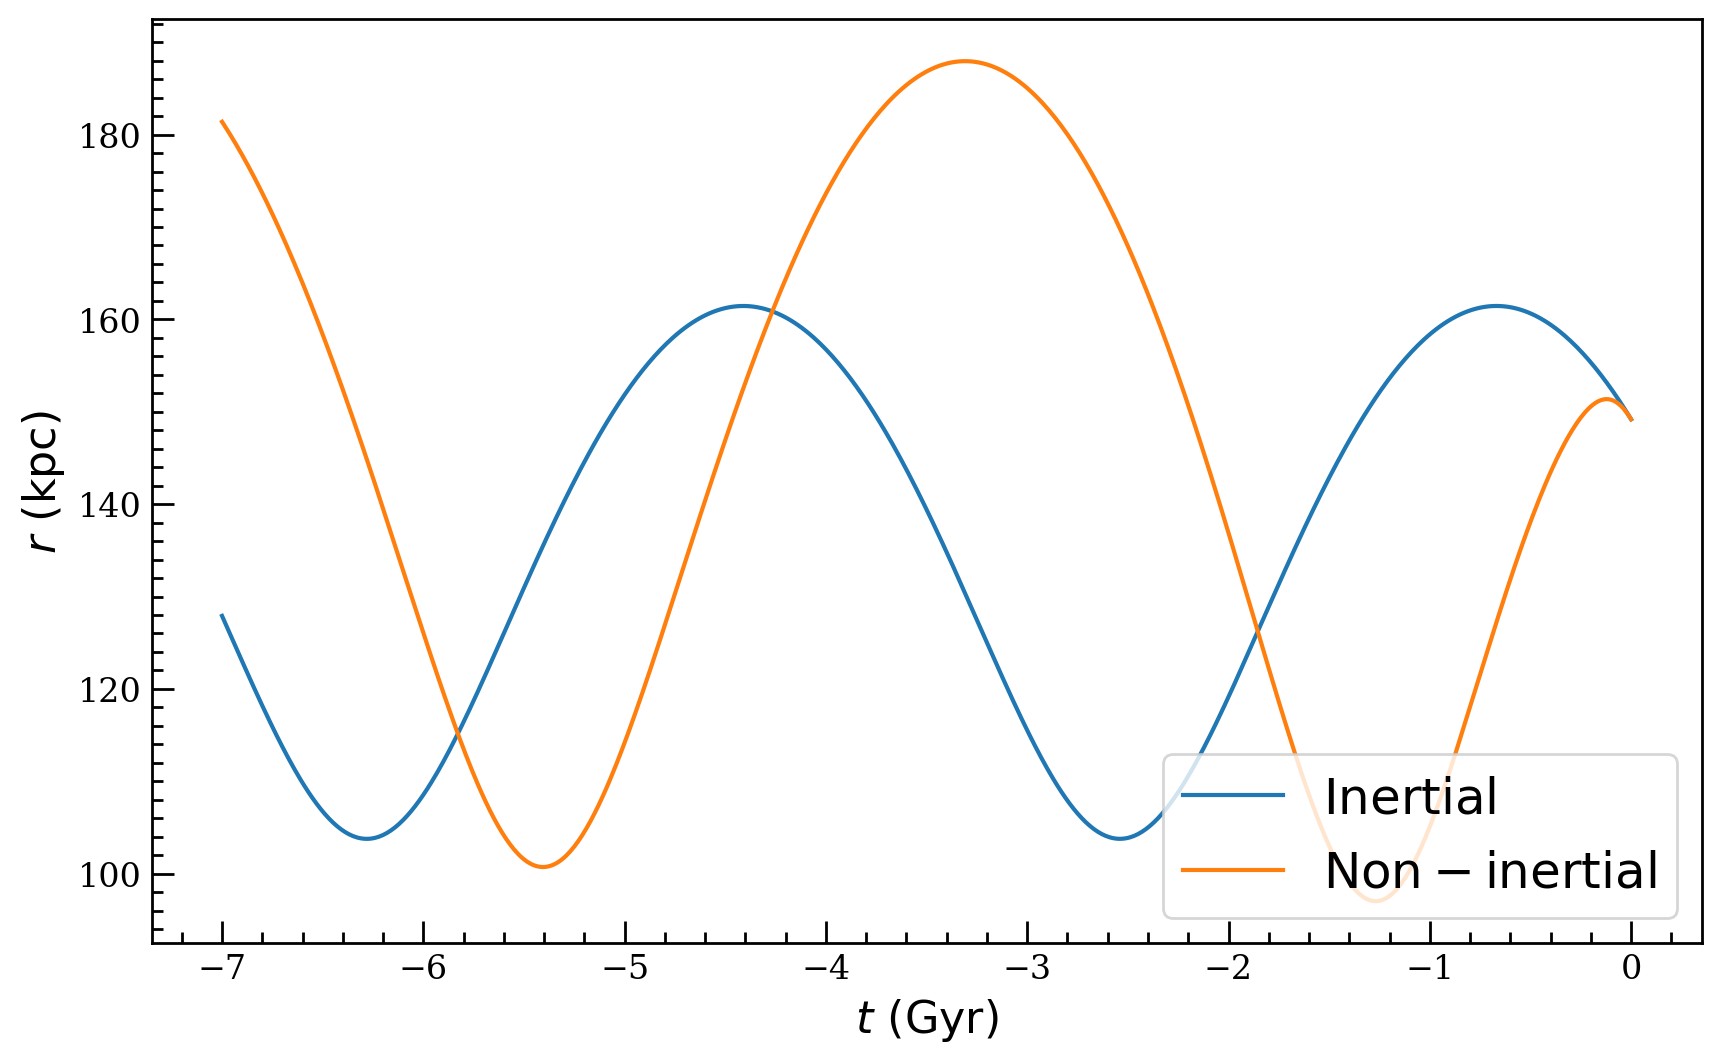

In [21]:
#Test on Fornax (delete)
fornaxts = np.linspace(0., -7., 701)*u.Gyr

ofornax_inertial = Orbit.from_name('Fornax')
ofornax_inertial.integrate(fornaxts, MWPotential2014)
ofornax_inertial.plotr(label = r'$\mathrm{Inertial}$')

ofornax_noninertial = Orbit.from_name('Fornax')
ofornax_noninertial.integrate(fornaxts, MWPotential2014 + nip + moving_lmcpot, method = 'dop853_c')
ofornax_noninertial.plotr(overplot = True, label=r'$\mathrm{Non-inertial}$')

plt.autoscale()
plt.legend(fontsize = 18.,loc ='lower right', framealpha=0.8)

In [22]:
o_wil1_lmc = Orbit(c_wil1) # define orbit from coordinates
o_wil1_lmc.integrate(t_step, MWPotential2014 + nip + moving_lmcpot) # integration to find orbit

In [23]:
# orbital parameters
pericenter_wil1_lmc = o_wil1_lmc.rperi()
apocenter_wil1_lmc = o_wil1_lmc.rap()
eccentricity_wil1_lmc = o_wil1_lmc.e()
zmax_wil1_lmc = o_wil1_lmc.zmax()
ellipticity_wil1_lmc = 1 - (1 - (eccentricity_wil1_lmc ** 2)) ** (1/2)

# orbit values
orbit_x_wil1_lmc = -o_wil1_lmc.x(t_step)
orbit_y_wil1_lmc = o_wil1_lmc.y(t_step)
orbit_z_wil1_lmc = o_wil1_lmc.z(t_step)
orbit_r_wil1_lmc = o_wil1_lmc.r(t_step)

print("Pericenter:   {:.3f} kpc \n".format(pericenter_wil1_lmc) + \
      "Apocenter:    {:.3f} kpc\n".format(apocenter_wil1_lmc) + \
      "Eccentricity: {:.3f}\n".format(eccentricity_wil1_lmc) + \
      "Zmax:         {:.3f} kpc\n".format(zmax_wil1_lmc) + \
      "Ellipticity:  {:.3f}".format(ellipticity_wil1_lmc))

Pericenter:   14.570 kpc 
Apocenter:    43.181 kpc
Eccentricity: 0.495
Zmax:         32.323 kpc
Ellipticity:  0.131


In [24]:
### bootstrapping
orbits_lmc = Orbit(c_bootstrap)
orbits_lmc.integrate(t_step, MWPotential2014 + nip + moving_lmcpot)

In [25]:
# orbital properties
pericenters_lmc    = orbits_lmc.rperi()
apocenters_lmc     = orbits_lmc.rap()
eccentricities_lmc = orbits_lmc.e()
radius_lmc         = orbits_lmc.r()
orbit_fperi_lmc    = (radius - pericenters) / (apocenters - pericenters)

print_vals(pericenters_lmc,    "Pericenter:     ", "kpc")
print_vals(apocenters_lmc,     "Apocenter:      ", "kpc")
print_vals(eccentricities_lmc, "Eccentricity:   ", "")
print_vals(radius_lmc,         "Current Radius: ", "kpc")
print_vals(orbit_fperi_lmc,    "F_peri:         ", "")

print("\nPericenters > 40 kpc: {}/{}.".format(len(pericenters_lmc[pericenters_lmc > 40]), num))

Pericenter:     14.711 + 1.886 - 1.683 kpc
Apocenter:      43.179 + 0.433 - 0.425 kpc
Eccentricity:   0.492 + 0.045 - 0.046 
Current Radius: 43.179 + 0.433 - 0.425 kpc
F_peri:         0.986 + 0.003 - 0.004 

Pericenters > 40 kpc: 0/1000.


In [26]:
# orbit values
orbit_r_lmc        = np.array([])
orbit_r_lower_lmc  = np.array([])
orbit_r_upper_lmc  = np.array([])
orbit_r_lower2_lmc = np.array([])
orbit_r_upper2_lmc = np.array([])

for i in range(len(t_step)): # loop through to find avg for each time step
    orbit_r_lmc        = np.append(orbit_r_lmc, np.median(orbits_lmc.r(t_step[i])))
    orbit_r_lower2_lmc = np.append(orbit_r_lower2_lmc, np.percentile(orbits_lmc.r(t_step[i]), 5))
    orbit_r_lower_lmc  = np.append(orbit_r_lower_lmc, np.percentile(orbits_lmc.r(t_step[i]), 16))
    orbit_r_upper_lmc  = np.append(orbit_r_upper_lmc, np.percentile(orbits_lmc.r(t_step[i]), 84))
    orbit_r_upper2_lmc = np.append(orbit_r_upper2_lmc, np.percentile(orbits_lmc.r(t_step[i]), 95))

## (4) W1 dynamical friction

In [27]:
cdf_w1 = ChandrasekharDynamicalFrictionForce(GMs = mass_w1[0] * u.Msun, rhm = r_half_pc * u.pc, 
                                             dens = MWPotential2014, minr = 0.1 * u.kpc, maxr = 50 * u.kpc)

o_wil1_lmc_cdf = Orbit(c_wil1) #define orbit from coordinates
o_wil1_lmc_cdf.integrate(t_step, MWPotential2014 + cdf_w1, method = 'dop853_c') #integration to find orbit

# orbital parameters
pericenter_wil1_lmc_cdf = o_wil1_lmc_cdf.rperi()
apocenter_wil1_lmc_cdf = o_wil1_lmc_cdf.rap()
eccentricity_wil1_lmc_cdf = o_wil1_lmc_cdf.e()
zmax_wil1_lmc_cdf = o_wil1_lmc_cdf.zmax()
ellipticity_wil1_lmc_cdf = 1 - (1 - (eccentricity_wil1_lmc_cdf ** 2)) ** (1/2)

print("Pericenter:   {:.3f} kpc \n".format(pericenter_wil1_lmc_cdf) + \
      "Apocenter:    {:.3f} kpc\n".format(apocenter_wil1_lmc_cdf) + \
      "Eccentricity: {:.3f}\n".format(eccentricity_wil1_lmc_cdf) + \
      "Zmax:         {:.3f} kpc\n".format(zmax_wil1_lmc_cdf) + \
      "Ellipticity:  {:.3f}".format(ellipticity_wil1_lmc_cdf))

# create orbital values
orbit_x_wil1_lmc_cdf = -o_wil1_lmc_cdf.x(t_step)
orbit_y_wil1_lmc_cdf = o_wil1_lmc_cdf.y(t_step)
orbit_z_wil1_lmc_cdf = o_wil1_lmc_cdf.z(t_step)
orbit_r_wil1_lmc_cdf = o_wil1_lmc_cdf.r(t_step)

Pericenter:   18.809 kpc 
Apocenter:    43.309 kpc
Eccentricity: 0.394
Zmax:         32.323 kpc
Ellipticity:  0.081


## Orbit comparison

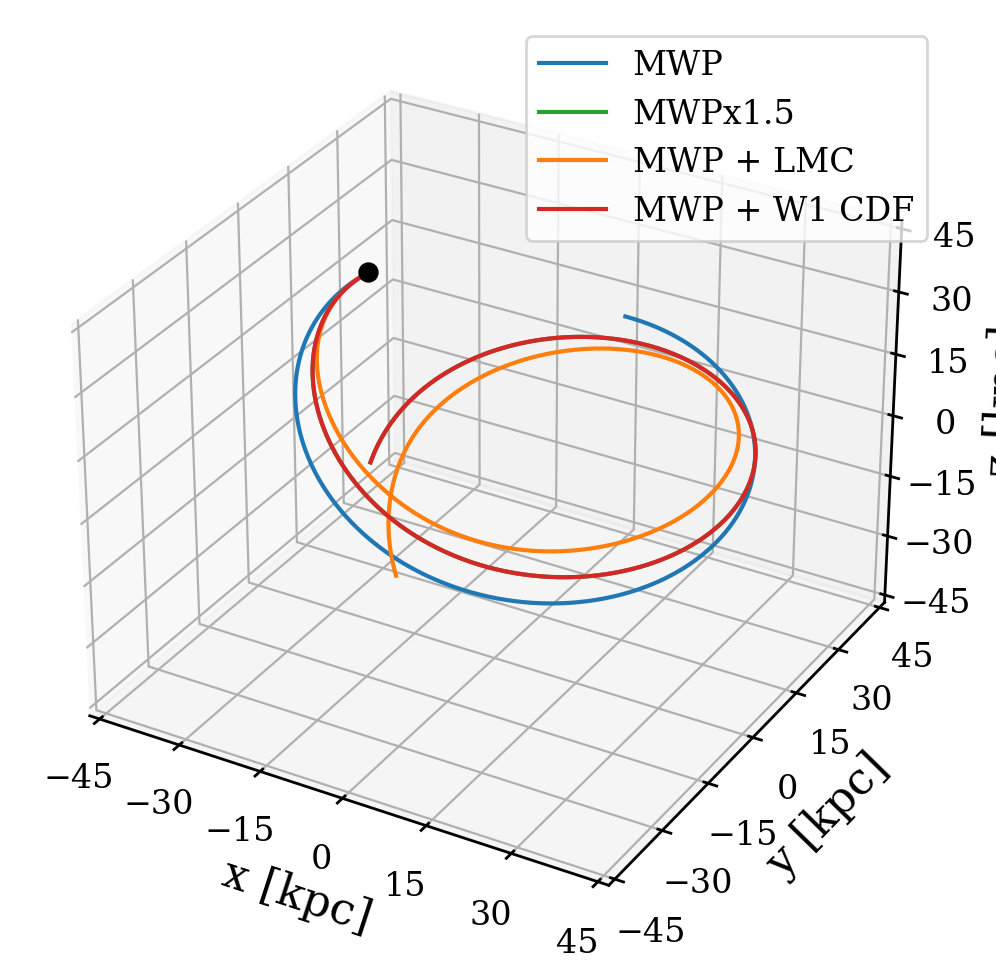

In [28]:
# 3d orbit
fig = plt.figure(figsize = (6, 6))
ax = plt.axes(projection = '3d')

ax.scatter3D(orbit_x_wil1[0], orbit_y_wil1[0], orbit_z_wil1[0], s = 40, c = 'black')

ax.plot3D(orbit_x_wil1, orbit_y_wil1, orbit_z_wil1, color = 'C0', linewidth = 1.5, label = "MWP")
ax.plot3D(orbit_x_wil1_inertial, orbit_y_wil1_inertial, orbit_z_wil1_inertial, color = 'C2', linewidth = 1.5, label = "MWPx1.5")
ax.plot3D(orbit_x_wil1_lmc, orbit_y_wil1_lmc, orbit_z_wil1_lmc, color = 'C1', linewidth = 1.5, label = "MWP + LMC")
ax.plot3D(orbit_x_wil1_lmc_cdf, orbit_y_wil1_lmc_cdf, orbit_z_wil1_lmc_cdf, color = 'C3', linewidth = 1.5, label = "MWP + W1 CDF")

ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)
ax.set_zlim(-40, 40)

ax.set_xlabel('x [kpc]', fontsize = 16)
ax.set_ylabel('y [kpc]', fontsize = 16)
ax.set_zlabel('z [kpc]', fontsize = 16)

ax.set_xticks(np.arange(-45, 60, 15), minor = False)
ax.tick_params(which = "major", axis = "x", direction = "out", size = 8, labelsize = 12, color = "black", top = True)

ax.set_yticks(np.arange(-45, 60, 15), minor = False)
ax.tick_params(which = "major", axis = "y", direction = "out", size = 8, labelsize = 12, color = "black", top = True)

ax.set_zticks(np.arange(-45, 60, 15), minor = False)
ax.tick_params(which = "major", axis = "z", direction = "out", size = 8, labelsize = 12, color = "black", top = True)

plt.legend(loc = "upper right", fontsize = 12)

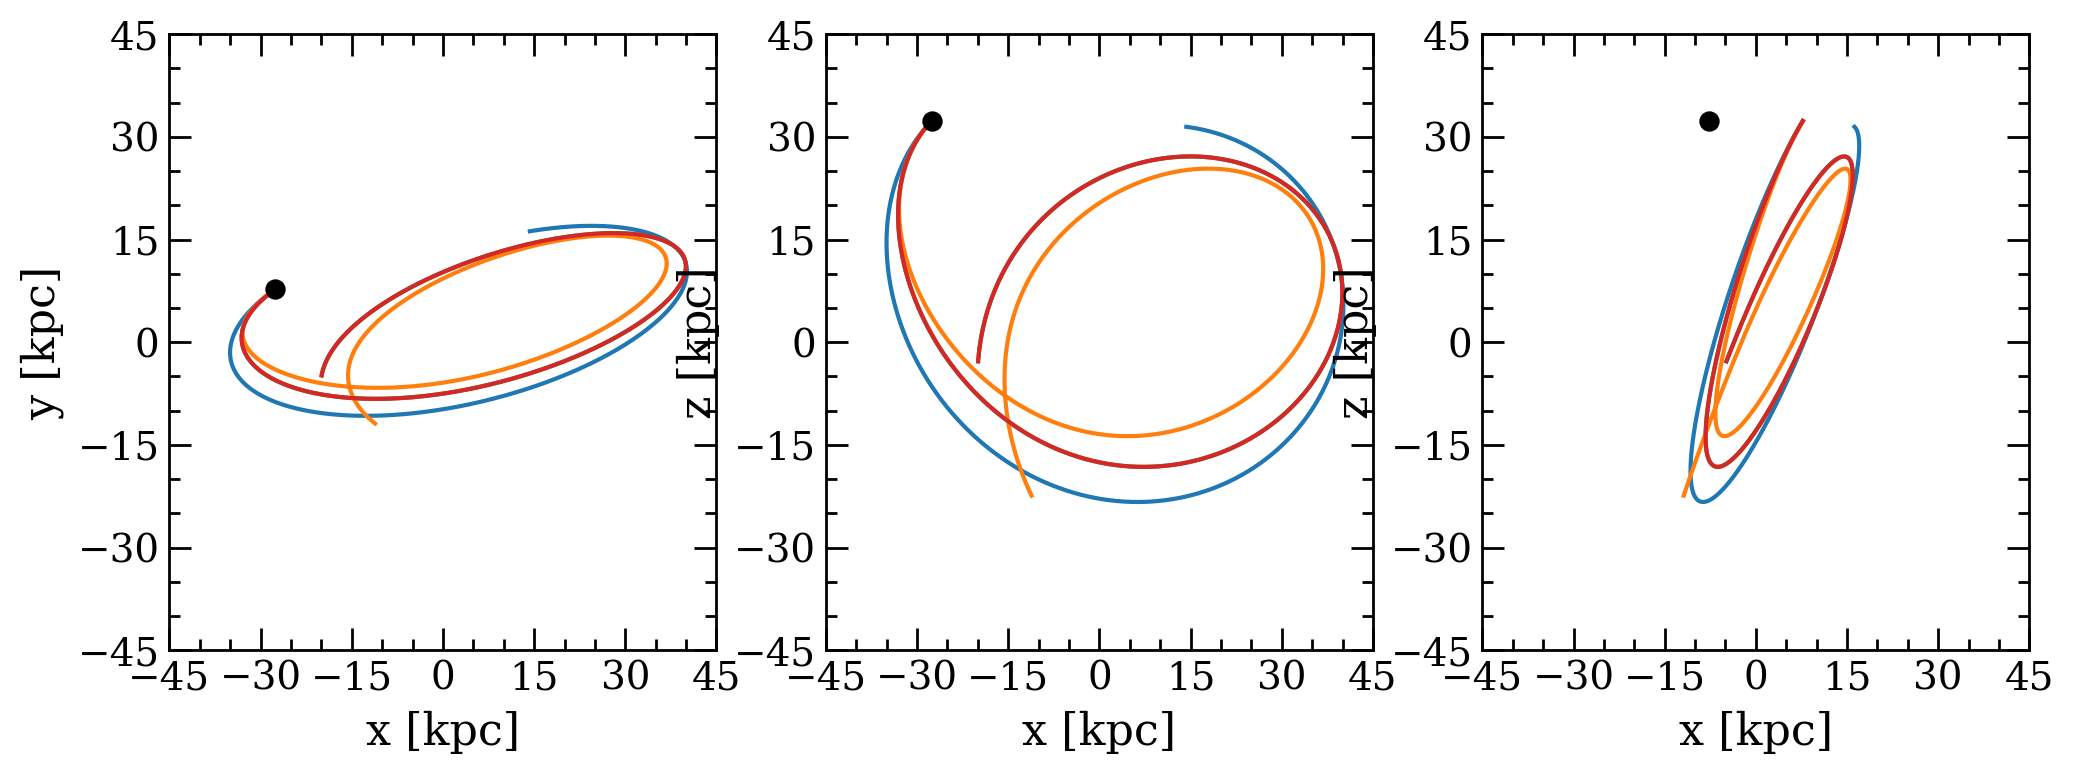

In [29]:
# projected orbits
fig, axes = plt.subplots(1, 3, figsize = (12, 4))

# x vs y
axes[0].plot(orbit_x_wil1, orbit_y_wil1, linewidth = 1.5, zorder = 0)
axes[0].plot(orbit_x_wil1_inertial, orbit_y_wil1_inertial, linewidth = 1.5, c = 'C2', zorder = 1)
axes[0].plot(orbit_x_wil1_lmc, orbit_y_wil1_lmc, linewidth = 1.5, c = 'C1', zorder = 2)
axes[0].plot(orbit_x_wil1_lmc_cdf, orbit_y_wil1_lmc_cdf, linewidth = 1.5, c = "C3", zorder = 3)
axes[0].scatter(-o_wil1.x(0), o_wil1.y(0), c = "black", s = 40, zorder = 4)

axes[0].set_xlabel("x [kpc]", labelpad = 5, size = 16)
axes[0].set_ylabel("y [kpc]", labelpad = 5, size = 16)

# x vs z
axes[1].plot(orbit_x_wil1, orbit_z_wil1, linewidth = 1.5, zorder = 0)
axes[1].plot(orbit_x_wil1_inertial, orbit_z_wil1_inertial, linewidth = 1.5, c = 'C2', zorder = 1)
axes[1].plot(orbit_x_wil1_lmc, orbit_z_wil1_lmc, linewidth = 1.5, c = 'C1', zorder = 2)
axes[1].plot(orbit_x_wil1_lmc_cdf, orbit_z_wil1_lmc_cdf, linewidth = 1.5, c = "C3", zorder = 3)
axes[1].scatter(-o_wil1.x(0), o_wil1.z(0), c = "black", s = 40, zorder = 3)

axes[1].set_xlabel("x [kpc]", labelpad = 5, size = 16)
axes[1].set_ylabel("z [kpc]", labelpad = 5, size = 16)

# y vs z
axes[2].plot(orbit_y_wil1, orbit_z_wil1, linewidth = 1.5, zorder = 0)
axes[2].plot(orbit_y_wil1_inertial, orbit_z_wil1_inertial, linewidth = 1.5, c = 'C2', zorder = 1)
axes[2].plot(orbit_y_wil1_lmc, orbit_z_wil1_lmc, linewidth = 1.5, c = 'C1', zorder = 2)
axes[2].plot(orbit_y_wil1_lmc_cdf, orbit_z_wil1_lmc_cdf, linewidth = 1.5, c = "C3", zorder = 3)
axes[2].scatter(-o_wil1.y(0), o_wil1.z(0), c = "black", s = 40, zorder = 3)

axes[2].set_xlabel("x [kpc]", labelpad = 5, size = 16)
axes[2].set_ylabel("z [kpc]", labelpad = 5, size = 16)

for ii in range(3):
    axes[ii].set_xticks(np.arange(-45, 60, 15), minor = False)
    axes[ii].set_xticks(np.arange(-45, 50, 5), minor = True)
    axes[ii].tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 14, color = "black", top = True)
    axes[ii].tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

    axes[ii].set_yticks(np.arange(-45, 60, 15), minor = False)
    axes[ii].set_yticks(np.arange(-45, 50, 5), minor = True)
    axes[ii].tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black", right = True)
    axes[ii].tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

## Figure 9: Orbit

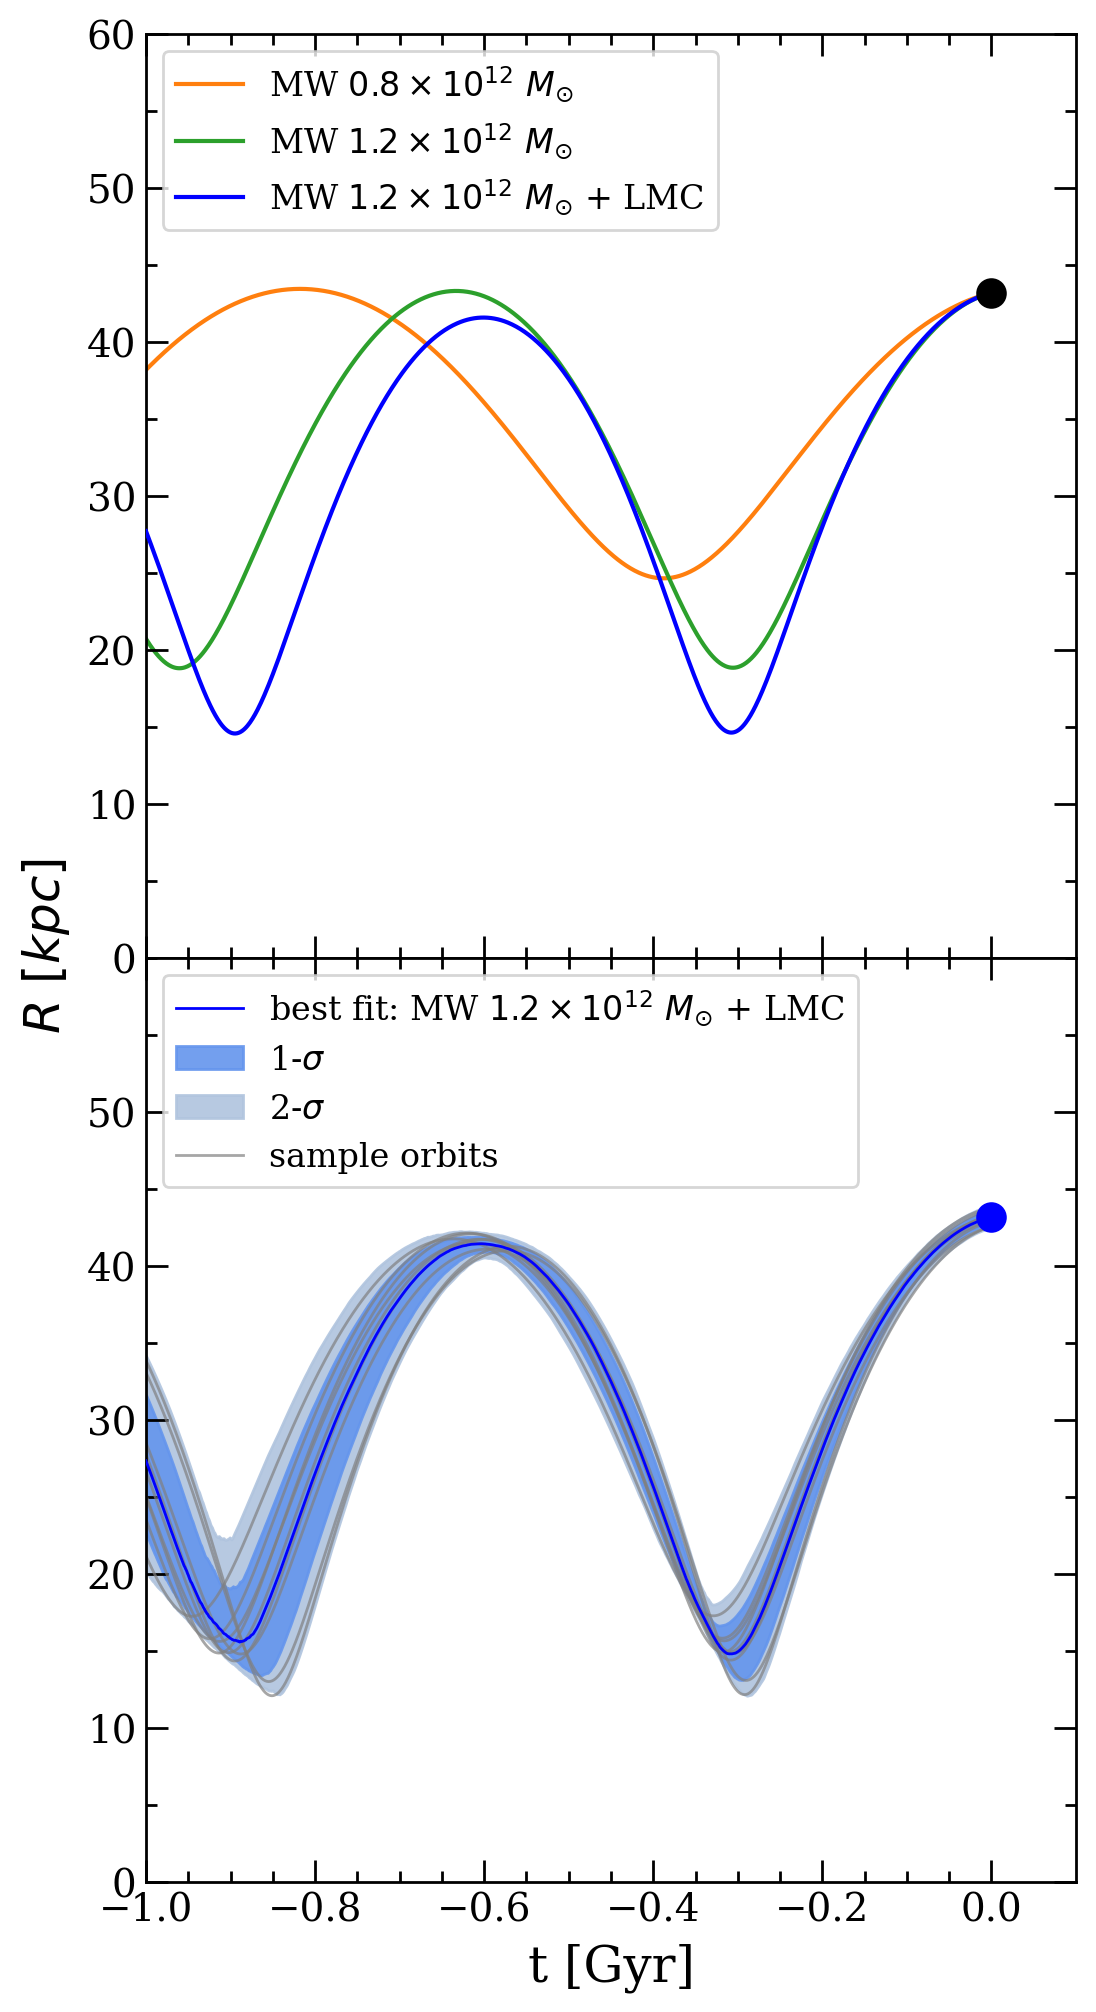

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(6, 12), sharex = True)
plt.subplots_adjust(hspace = 0) 
total_ax = axes.ravel().tolist()

#### comparison orbit
axes[0].plot(t_step, orbit_r_wil1, linewidth = 1.5, c = "C1", zorder = 1, label = r"MW $0.8 \times 10^{12}~M_{\odot}$")
axes[0].plot(t_step, orbit_r_wil1_inertial, linewidth = 1.5, c = "C2", zorder = 1, label = r"MW $1.2 \times 10^{12}~M_{\odot}$")
axes[0].plot(t_step, orbit_r_wil1_lmc, linewidth = 1.5, c = "blue", zorder = 3, label = r"MW $1.2 \times 10^{12}~M_{\odot}$ + LMC")
axes[0].scatter(0, o_wil1.r(0), c = "black", s = 100, zorder = 3)

axes[0].set_xticks(np.arange(-1, 0.2, 0.2), minor = False)
axes[0].set_xticks(np.arange(-1, 0.05, 0.05), minor = True)
axes[0].tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 14, color = "black", top = True)
axes[0].tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

axes[0].set_yticks(np.arange(0, 70, 10), minor = False)
axes[0].set_yticks(np.arange(0, 65, 5), minor = True)
axes[0].tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black", right = True)
axes[0].tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

axes[0].legend(loc = "upper left", fontsize = 12)

#### bootstrapped orbit
axes[1].fill_between(t_step.value, orbit_r_lower2_lmc, orbit_r_upper2_lmc, alpha=0.9, color = "lightsteelblue", label = r"2-$\sigma$")
axes[1].fill_between(t_step.value, orbit_r_lower_lmc, orbit_r_upper_lmc, alpha=0.9, color = "cornflowerblue", label = r"1-$\sigma$")

axes[1].plot(t_step, orbits_lmc[50].r(t_step), c = "grey", linewidth = 1, alpha = 0.7, label = "sample orbits")
axes[1].plot(t_step, orbits_lmc[150].r(t_step), c = "grey", linewidth = 1, alpha = 0.7)
axes[1].plot(t_step, orbits_lmc[250].r(t_step), c = "grey", linewidth = 1, alpha = 0.7)
axes[1].plot(t_step, orbits_lmc[350].r(t_step), c = "grey", linewidth = 1, alpha = 0.7)
axes[1].plot(t_step, orbits_lmc[450].r(t_step), c = "grey", linewidth = 1, alpha = 0.7)
axes[1].plot(t_step, orbits_lmc[650].r(t_step), c = "grey", linewidth = 1, alpha = 0.7)
axes[1].plot(t_step, orbits_lmc[750].r(t_step), c = "grey", linewidth = 1, alpha = 0.7)
axes[1].plot(t_step, orbits_lmc[850].r(t_step), c = "grey", linewidth = 1, alpha = 0.7)
axes[1].plot(t_step, orbits_lmc[950].r(t_step), c = "grey", linewidth = 1, alpha = 0.7)

axes[1].plot(t_step, orbit_r_lmc, linewidth = 1, c = "blue", zorder = 15, label = r"best fit: MW $1.2 \times 10^{12}~M_{\odot}$ + LMC")
axes[1].scatter(0, orbit_r[0], c = "blue", s = 100, zorder = 15)

axes[1].set_xlabel("t [Gyr]", labelpad = 5, size = 18).set_color('black')

axes[1].set_xlim(-1., 0.1)
axes[1].set_ylim(0, 60)

axes[1].set_xticks(np.arange(-1, 0.2, 0.2), minor = False)
axes[1].set_xticks(np.arange(-1, 0.05, 0.05), minor = True)
axes[1].tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 14, color = "black", top = True)
axes[1].tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

axes[1].set_yticks(np.arange(0, 60, 10), minor = False)
axes[1].set_yticks(np.arange(0, 65, 5), minor = True)
axes[1].tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black", right = True)
axes[1].tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 1, 0, 2]

axes[1].legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc = "upper left", fontsize = 12)

fig.supylabel("$R~[kpc]$", size = 18).set_color('black')

plt.savefig("plots/7_orbit.pdf", dpi = 600, transparent = True)

#### Half-light radius

In [31]:
def calc_tidalr(lower_m, m_w1, upper_m, lower_R, R_w1, upper_R, p = 1):
    mw_mass  = galpy.potential.mass(MWPotential2014, R = R_w1) * conversion.mass_in_msol(vo = 220., ro = 8.34)
    mw_lower = mw_mass - galpy.potential.mass(MWPotential2014, R = R_w1 - lower_R) * conversion.mass_in_msol(vo = 220., ro = 8.34)
    mw_upper = galpy.potential.mass(MWPotential2014, R = upper_R + R_w1) * conversion.mass_in_msol(vo = 220., ro = 8.34) - mw_mass
    
    tidal = 1e3 * R_w1 * (m_w1 / (3 * mw_mass)) ** (1/3)
    lower_tidal = tidal * (((lower_R / R_w1) ** 2 + (lower_m / m_w1) ** 2) + (mw_lower / mw_mass) ** 2) ** 0.5
    upper_tidal = tidal * (((upper_R / R_w1) ** 2 + (upper_m / m_w1) ** 2) + (mw_upper / mw_mass) ** 2) ** 0.5
    
    tidal_rhalf = tidal / r_half_pc
    lower_tidal_rhalf = tidal_rhalf * (((lower_R / R_w1) ** 2 + (1/9) * (lower_m / m_w1) ** 2) + (1/9) * (mw_lower / mw_mass) ** 2 + (r_half_pc_err / r_half_pc) ** 2) ** 0.5
    upper_tidal_rhalf = tidal_rhalf * (((upper_R / R_w1) ** 2 + (1/9) * (upper_m / m_w1) ** 2) + (1/9) * (mw_upper / mw_mass) ** 2 + (r_half_pc_err / r_half_pc) ** 2) ** 0.5
    
    if p:
        print("R_J = {:.3f} + {:.3f} - {:.3f} pc".format(tidal, upper_tidal, lower_tidal))
        print("R_J = {:.3f} + {:.3f} - {:.3f} rhalf".format(tidal_rhalf, upper_tidal_rhalf, lower_tidal_rhalf))
    
    return lower_tidal, tidal, upper_tidal, lower_tidal_rhalf, tidal_rhalf, upper_tidal_rhalf

In [32]:
# current tidal radius
current_lower = np.percentile(radius_lmc, 50) - np.percentile(radius_lmc, 16)
current       = np.percentile(radius_lmc, 50)
current_upper = np.percentile(radius_lmc, 84) - np.percentile(radius_lmc, 50)

__ = calc_tidalr(mass_w1[2], mass_w1[0], mass_w1[1], current_lower, current, current_upper)

R_J = 216.617 + 123.845 - 137.696 pc
R_J = 7.696 + 1.618 - 1.768 rhalf


In [33]:
# calculate tidal radius at pericenter
peri_lower = np.percentile(pericenters_lmc, 50) - np.percentile(pericenters_lmc, 16)
peri       = np.percentile(pericenters_lmc, 50)
peri_upper = np.percentile(pericenters_lmc, 84) - np.percentile(pericenters_lmc, 50)

__ = calc_tidalr(mass_w1[2], mass_w1[0], mass_w1[1], peri_lower, peri, peri_upper)

R_J = 87.762 + 51.783 - 56.997 pc
R_J = 3.118 + 0.771 - 0.803 rhalf


In [34]:
radius = np.arange(0.02, 50.02, 0.02)
tidal_radius_r_lower, tidal_radius_r, tidal_radius_r_upper = np.array([]), np.array([]), np.array([])
tidal_radius_r_lower2, tidal_radius_r_upper2 = np.array([]), np.array([])

for i in range(len(radius)):
    rt       = calc_tidalr(0, mass_w1[0], 0, 0, radius[i], 0, p = 0)
    rt_lower = calc_tidalr(0, mass_w1[0] - mass_w1[2], 0, 0, radius[i], 0, p = 0)
    rt_upper = calc_tidalr(0, mass_w1[0] + mass_w1[1], 0, 0, radius[i], 0, p = 0)

    tidal_radius_r_lower  = np.append(tidal_radius_r_lower, rt_lower[1])
    tidal_radius_r        = np.append(tidal_radius_r, rt[1])
    tidal_radius_r_upper  = np.append(tidal_radius_r_upper, rt_upper[1])
    # tidal_radius_r_lower2 = np.append(tidal_radius_r_lower2, rt_lower2[1])
    # tidal_radius_r_upper2 = np.append(tidal_radius_r_upper2, rt_upper2[1])

radius_orbit = np.arange(np.percentile(pericenters, 50), np.percentile(apocenters, 50), 0.02)
tidal_radius_orbit = np.array([])
for i in range(len(radius_orbit)):
    rt = calc_tidalr(0, mass_w1[0], 0, 0, radius_orbit[i], 0, p = 0)
    tidal_radius_orbit = np.append(tidal_radius_orbit, rt[1])

In [35]:
tidal_radius        = np.array([])
tidal_radius_lower  = np.array([])
tidal_radius_upper  = np.array([])
tidal_radius_lower2 = np.array([])
tidal_radius_upper2 = np.array([])

for i in range(len(orbit_r_lmc)):
    rt        = calc_tidalr(0, mass_w1[0], 0, 0, orbit_r_lmc[i], 0, p = 0)
    rt_lower  = calc_tidalr(0, mass_w1[0], 0, 0, orbit_r_lower_lmc[i], 0, p = 0)
    rt_upper  = calc_tidalr(0, mass_w1[0], 0, 0, orbit_r_upper_lmc[i], 0, p = 0)
    rt_lower2 = calc_tidalr(0, mass_w1[0], 0, 0, orbit_r_lower2_lmc[i], 0, p = 0)
    rt_upper2 = calc_tidalr(0, mass_w1[0], 0, 0, orbit_r_upper2_lmc[i], 0, p = 0)

    tidal_radius        = np.append(tidal_radius, rt[1])
    tidal_radius_lower  = np.append(tidal_radius_lower, rt_lower[1])
    tidal_radius_upper  = np.append(tidal_radius_upper, rt_upper[1])
    tidal_radius_lower2 = np.append(tidal_radius_lower2, rt_lower2[1])
    tidal_radius_upper2 = np.append(tidal_radius_upper2, rt_upper2[1])

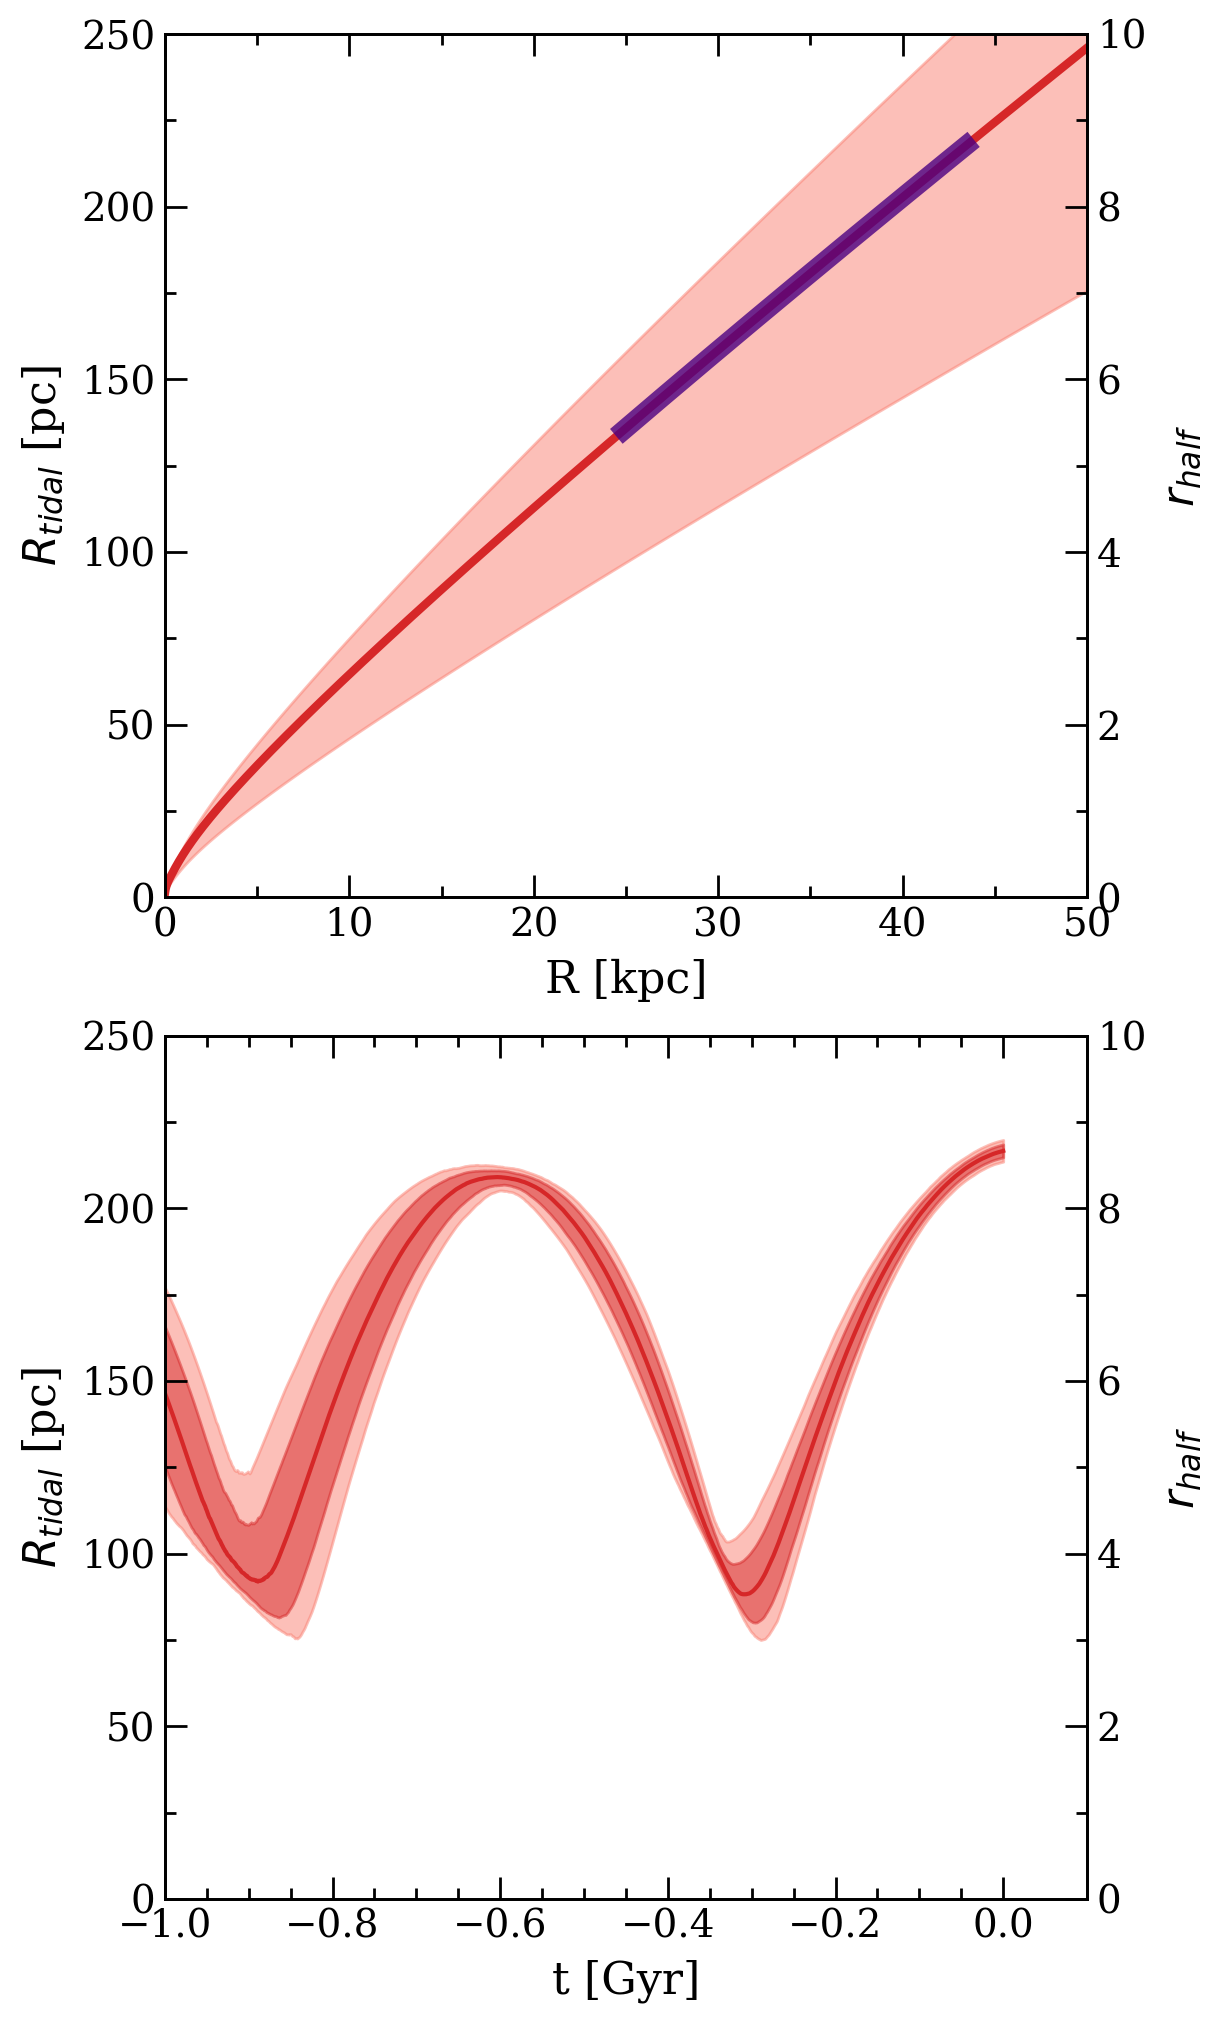

In [36]:
fig, ax = plt.subplots(2, 1, figsize = (6,10), constrained_layout = True)

ax[0].fill_between(radius, tidal_radius_r_lower, tidal_radius_r_upper, color = "salmon", alpha=0.5)
ax[0].plot(radius, tidal_radius_r, linewidth = 3, c = "C3", zorder = 2) 
ax[0].plot(radius_orbit, tidal_radius_orbit, linewidth = 7, c = "indigo", alpha = 0.8, zorder = 2) 

ax[0].set_xlabel("R [kpc]", labelpad = 5, size = 16).set_color('black')
ax[0].set_ylabel(r"$R_{tidal}$ [pc]", labelpad = 5, size = 16).set_color('black')

ax[0].set_xlim(0, 50)
ax[0].set_ylim(0, 250)
    
ax1 = ax[0].twinx()
mn, mx = ax[0].get_ylim()
ax1.set_ylim(mn / r_half_pc, mx / r_half_pc)
ax1.set_ylabel(r'$r_{half}$', labelpad = 5, size = 16).set_color('black')
ax1.set_yticks(np.arange(0, 12, 2), minor = False)
ax1.set_yticks(np.arange(0, 11, 1), minor = True)
ax1.tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black")
ax1.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black")

ax[0].set_xticks(np.arange(0, 60, 10), minor = False)
ax[0].set_xticks(np.arange(0, 55, 5), minor = True)
ax[0].tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 14, color = "black", top = True)
ax[0].tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax[0].set_yticks(np.arange(0, 300, 50), minor = False)
ax[0].set_yticks(np.arange(0, 275, 25), minor = True)
ax[0].tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black")
ax[0].tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black")

### TIDAL RADIUS PLOT
ax[1].fill_between(t_step.value, tidal_radius_lower2, tidal_radius_upper2, color = "salmon", alpha=0.5)
ax[1].fill_between(t_step.value, tidal_radius_lower, tidal_radius_upper, color = "C3", alpha=0.5)
ax[1].plot(t_step, tidal_radius, linewidth = 1.5, c = "C3", zorder = 2) 

ax[1].set_xlabel("t [Gyr]", labelpad = 5, size = 16).set_color('black')
ax[1].set_ylabel(r"$R_{tidal}$ [pc]", labelpad = 5, size = 16).set_color('black')

ax[1].set_xlim(-1., 0.1)
ax[1].set_ylim(0, 250)

ax2 = ax[1].twinx()
mn, mx = ax[1].get_ylim()
ax2.set_ylim(mn / r_half_pc, mx / r_half_pc)
ax2.set_ylabel(r'$r_{half}$', labelpad = 5, size = 16).set_color('black')
ax2.set_yticks(np.arange(0, 12, 2), minor = False)
ax2.set_yticks(np.arange(0, 11, 1), minor = True)
ax2.tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black")
ax2.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black")

ax[1].set_xticks(np.arange(-1, 0.2, 0.2), minor = False)
ax[1].set_xticks(np.arange(-1, 0.05, 0.05), minor = True)
ax[1].tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 14, color = "black", top = True)
ax[1].tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax[1].set_yticks(np.arange(0, 300, 50), minor = False)
ax[1].set_yticks(np.arange(0, 275, 25), minor = True)
ax[1].tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black")
ax[1].tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black")

# plt.savefig("tidal_radius.pdf", dpi = 600, transparent = True)